# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Anaconda\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

In [14]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english')) #set of stopwords
words_to_keep = set(('not'))
stop -= words_to_keep

sno = nltk.stem.SnowballStemmer('english')
def cleanhtml(sentence): #function to clean any HTML Tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean any word of punctuation or special character
    cleaned = re.sub(r'[?|!|\'|"|#]',r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ', cleaned)
    return cleaned

In [15]:
#code for implementing step by step check mentioned in preprocessing phase
#runtime wiil be high due to 500k sentences
i = 0
str1 = ' '
final_string = []
all_positive_words = []
all_negative_words = []
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1)
    i+=1

In [16]:
final['cleanedText']=final_string #Adding a column of Cleanedtext which displays data after preprocesing.
final['cleanedText']=final['cleanedText'].str.decode("utf-8")
print('shape of final', final.shape)
final.head()

shape of final (87773, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infest fruitfli liter everywher fli around kit...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate star...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish read review make purchas basic cardsotck ...


## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

#### TimeBasedSplitting of data

In [17]:
#sorting data according to time in ascending oreder for time based splitting
from sklearn.model_selection import train_test_split
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
x = time_sorted_data['cleanedText'].values
y = time_sorted_data['Score']
#SPlit the dataset into Train and Test
X_train,X_test,Y_train,Y_test=train_test_split(x, y, test_size=0.3, random_state=0)

In [18]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [19]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [21]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [22]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [23]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [24]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [25]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [26]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████| 87773/87773 [01:28<00:00, 991.29it/s]


In [28]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [29]:
## Similartly you can do preprocessing for review summary also.
from tqdm import tqdm
preprocessed_summaries = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summaries.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:00<00:00, 1439.14it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [27]:
# Please write all the code with proper documentation
#Bow
count_vect = CountVectorizer(min_df =100)
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_vec))
print("the shape of out text BOW vectorizer ",X_train_vec.get_shape())
print("the number of unique words ", X_train_vec.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (61441, 2073)
the number of unique words  2073


In [28]:
#Standardizing
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

#### GridSearchCV implementation SGDClassifier(With Hinge-Loss)

In [29]:
# Importing libraries
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from scipy import *
from scipy.sparse import *
from scipy.stats import uniform
from prettytable import PrettyTable

Alpha = [0.001, 0.01, 0.1, 1, 10]
param_grid={'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The Optimal value Of alpha(1/C) is : ", optimal_alpha)

#SGDClassifier with  Optimal value of alpha:(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized, Y_train)

# linear svc with sigmoid calibration
calib = CalibratedClassifierCV(sgd, method = "sigmoid", cv = "prefit")
calib.fit(X_train_vec_standardized, Y_train)
predictions = sgd.predict(X_test_vec_standardized)
# Predict probabilistic response
pred_prob = calib.predict_proba(X_test_vec_standardized)[:,1]

#varibles will be used at conclusion part
bow_grid_alpha = optimal_alpha
bow_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of model :  0.913186709455
The Optimal value Of alpha(1/C) is :  0.1


In [39]:
#ROC curve over Test Data
from sklearn.metrics import roc_curve
metrics.roc_curve(Y_test,pred_prob)

(array([  0.00000000e+00,   0.00000000e+00,   2.36183278e-04, ...,
          9.97874350e-01,   9.97874350e-01,   1.00000000e+00]),
 array([  1.35758892e-04,   1.49334781e-03,   1.49334781e-03, ...,
          9.99954747e-01,   1.00000000e+00,   1.00000000e+00]),
 array([  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          9.69457565e-07,   7.20385550e-07,   1.26184867e-08]))

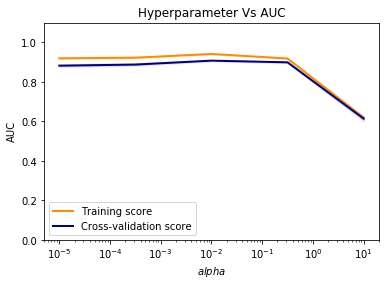

In [57]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="roc_auc", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Hyperparameter Vs AUC")
plt.xlabel("$alpha$")
plt.ylabel("AUC")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

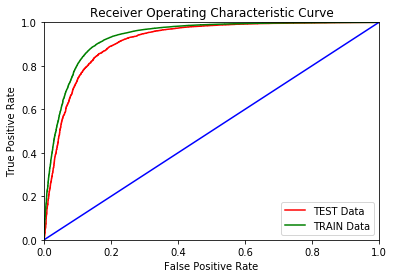

In [29]:
from cycler import cycler
fpr, tpr, threshold = metrics.roc_curve(Y_test, calib.predict_proba(X_test_vec_standardized)[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(Y_train, calib.predict_proba(X_train_vec_standardized)[:,1])

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [37]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_alpha, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))


Test Accuracy Of Classifier C = 0.100 is 91.329941%

Test Precsion Of Classifier C = 0.100 is 0.925269

Test recall  Of Classifier C = 0.100 is 0.975473

Test F1-score  Of Classifier C = 0.100 is 0.949708


Train Confusion Matrix
[[ 6246  3701]
 [ 1078 50416]]
Test Confusion Matrix
[[ 2493  1741]
 [  542 21556]]


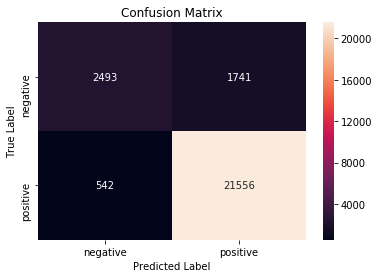

In [38]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, sgd.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### RandomizedSearchCv (with HInge-Loss)

In [63]:
from scipy.stats import uniform
# create regularization hyperparameter distribution using uniform distribution
Alpha = uniform(loc=0,scale=1)
# create hyperparamaters options
hyperparameters = dict(alpha=Alpha)
# Using RandomSearchCv
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The Optimal value Of Aplha(1/C) is : ", optimal_alpha)

#SGDClassifier with  Optimal value of alpha:(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized, Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Predict probabilistic response
pred_prob = calib.predict_proba(X_test_vec_standardized)[:,1]

#varibles will be used at conclusion part
bow_random_alpha = optimal_alpha
bow_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.068002930491750768, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of model :  0.914437450507
The Optimal value Of Aplha(1/C) is :  0.0680029304918


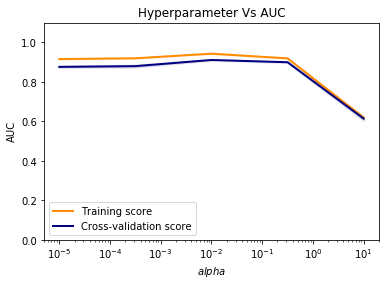

In [64]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="roc_auc", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Hyperparameter Vs AUC")
plt.xlabel("$alpha$")
plt.ylabel("AUC")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

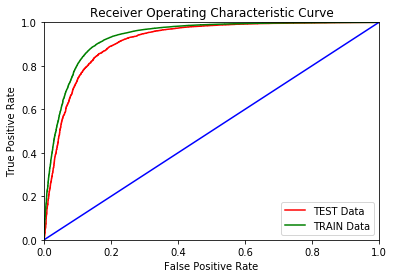

In [30]:
from cycler import cycler
fpr, tpr, threshold = metrics.roc_curve(Y_test, calib.predict_proba(X_test_vec_standardized)[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(Y_train, calib.predict_proba(X_train_vec_standardized)[:,1])

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_alpha, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))


Test Accuracy Of Classifier C = 0.090 is 91.318548%

Test Precsion Of Classifier C = 0.090 is 0.925150

Test recall  Of Classifier C = 0.090 is 0.975473

Test F1-score  Of Classifier C = 0.090 is 0.949645


#### Top 20 Important Features From SET1

In [31]:
# Please write all the code with proper documentation
#top 10 positive features
all_features = count_vect.get_feature_names()
model=SGDClassifier(alpha=0.1)
model.fit(X_train_vec_standardized,Y_train)
weight=model.coef_
pos_indx=np.argsort(weight)[:,::-1]

neg_indx=np.argsort(weight)

print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(all_features[i])

Top 10 positive features :
great
love
good
best
delici
perfect
excel
nice
favorit
wonder


In [32]:
#top 10 negative features
print('Top 10 negative features :')
for i in list(neg_indx[0][0:10]):
    print(all_features[i])

Top 10 negative features :
disappoint
worst
horribl
aw
return
terribl
bad
unfortun
wast
stale


Train Confusion Matrix
[[ 6212  3735]
 [ 1051 50443]]
Test Confusion Matrix
[[ 2490  1744]
 [  542 21556]]


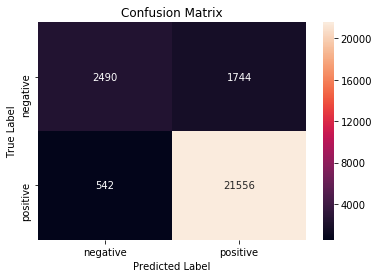

In [41]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, sgd.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:
* Observed an AUC of 0.912 using GridSearchCV with an Optimal(Alpha) 0.1
* Observed an AUC of 0.913 using RandomSearchCV with SGD calssifier
* With train and test confusion matrix

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [33]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(min_df=100)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_vec))
print("the shape of out text TFIDF vectorizer ",X_train_vec.get_shape())
print("the number of unique words ", X_train_vec.get_shape()[1])

#Standardizing
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (61441, 2073)
the number of unique words  2073


#### GridSearchCV (SGDClassifier with Hinge-Loss)

In [34]:
Alpha = [0.001, 0.01, 0.1, 1, 10]
param_grid={'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The Optimal value Of alpha(1/C) is : ", optimal_alpha)

#SGDClassifier with  Optimal value of alpha:(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized, Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Predict probabilistic response
pred_prob = calib.predict_proba(X_test_vec_standardized)[:,1]

#varibles will be used at conclusion part
tfidf_grid_alpha = optimal_alpha
tfidf_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of model :  0.935722632121
The Optimal value Of alpha(1/C) is :  0.1


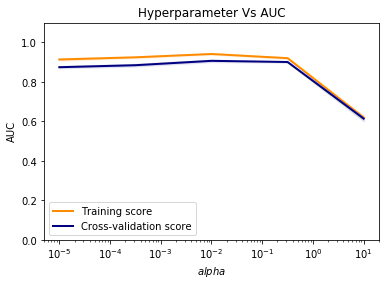

In [67]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="roc_auc", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Hyperparameter Vs AUC")
plt.xlabel("$alpha$")
plt.ylabel("AUC")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

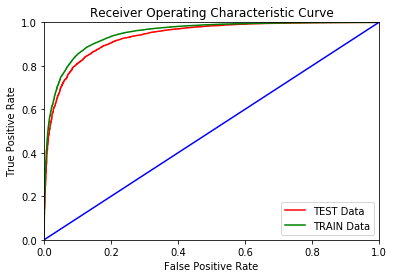

In [33]:
from cycler import cycler
fpr, tpr, threshold = metrics.roc_curve(Y_test, calib.predict_proba(X_test_vec_standardized)[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(Y_train, calib.predict_proba(X_train_vec_standardized)[:,1])

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [68]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_alpha, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))


Test Accuracy Of Classifier C = 0.100 is 91.291964%

Test Precsion Of Classifier C = 0.100 is 0.924253

Test recall  Of Classifier C = 0.100 is 0.976242

Test F1-score  Of Classifier C = 0.100 is 0.949537


Train Confusion Matrix
[[ 5952  3995]
 [  950 50544]]
Test Confusion Matrix
[[ 2349  1885]
 [  458 21640]]


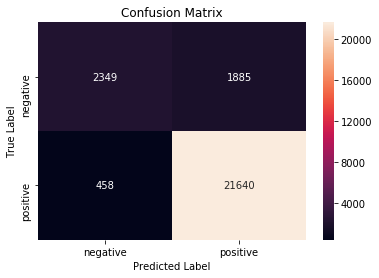

In [45]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, sgd.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### RandomizedSearchCV (SGDClassifier with Hinge-Loss)

In [71]:
from scipy.stats import uniform
# create regularization hyperparameter distribution using uniform distribution
Alpha = uniform(loc=0,scale=1)
# create hyperparamaters options
hyperparameters = dict(alpha=Alpha)
# Using RandomSearchCv
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The Optimal value Of Aplha(1/C) is : ", optimal_alpha)

#SGDClassifier with  Optimal value of alpha:(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized, Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Predict probabilistic response
pred_prob = calib.predict_proba(X_test_vec_standardized)[:,1]

#varibles will be used at conclusion part
tfidf_random_alpha = optimal_alpha
tfidf_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.55645726108106475, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of model :  0.885571018659
The Optimal value Of Aplha(1/C) is :  0.556457261081


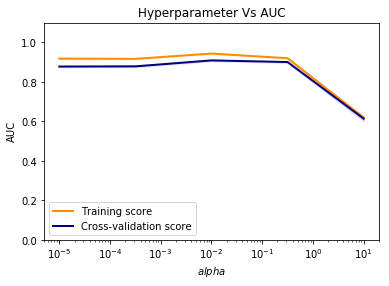

In [72]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="roc_auc", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Hyperparameter Vs AUC")
plt.xlabel("$alpha$")
plt.ylabel("AUC")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

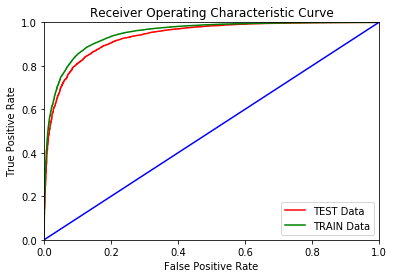

In [34]:
from cycler import cycler
fpr, tpr, threshold = metrics.roc_curve(Y_test, calib.predict_proba(X_test_vec_standardized)[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(Y_train, calib.predict_proba(X_train_vec_standardized)[:,1])

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_alpha, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))


Test Accuracy Of Classifier C = 0.050 is 91.216011%

Test Precsion Of Classifier C = 0.050 is 0.924771

Test recall  Of Classifier C = 0.050 is 0.974613

Test F1-score  Of Classifier C = 0.050 is 0.949038


#### Top Important Features 

In [35]:
#top 10 positive features
all_features = tf_idf_vect.get_feature_names()
model=SGDClassifier(alpha=0.1)
model.fit(X_train_vec_standardized,Y_train)
weight=model.coef_
pos_indx=np.argsort(weight)[:,::-1]

neg_indx=np.argsort(weight)

print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(all_features[i])

Top 10 positive features :
great
love
good
best
delici
perfect
excel
nice
favorit
find


In [36]:
#top 10 negative features
print('Top 10 negative features :')
for i in list(neg_indx[0][0:10]):
    print(all_features[i])

Top 10 negative features :
disappoint
worst
horribl
aw
return
terribl
unfortun
threw
disgust
wast


Train Confusion Matrix
[[ 6329  3618]
 [ 1050 50444]]
Test Confusion Matrix
[[ 2482  1752]
 [  561 21537]]


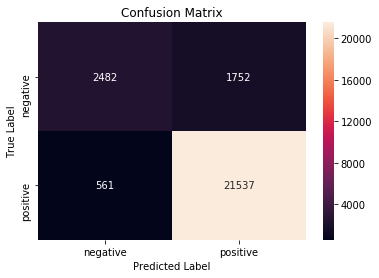

In [48]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, sgd.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:
* SGD calssifier with Hinge-loss on TFIDF model with AUC 0.910 with an Optimal Hyperparameter 0.1
* Using Random SearchCV obsreved a AUC of 0.913 with an Optimal ALpha of 0.049

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [35]:
# Please write all the code with proper documentation
#List of sentance in X_train text
sent_of_train = []
for sent in X_train:
    sent_of_train.append(sent.split())
    
#List of sentance in X_test text
sent_of_test = []
for sent in X_test:
    sent_of_test.append(sent.split())
#Train your own text corpus WOrd2Vec
w2v_model = Word2Vec(sent_of_train,min_count=5,size=50,workers=4)   
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9941
sample words  ['weekend', 'week', 'long', 'fast', 'use', 'rice', 'green', 'tea', 'work', 'wonder', 'one', 'energi', 'level', 'tasti', 'even', 'bit', 'salt', 'make', 'much', 'pleasant', 'famili', 'favorit', 'flavor', 'hansen', 'diet', 'soda', 'clean', 'crisp', 'tast', 'enjoy', 'meal', 'calm', 'upset', 'tummi', 'love', 'compar', 'eat', 'like', 'nissin', 'maruchan', 'realli', 'tell', 'differ', 'big', 'tub', 'spice', 'drop', 'better', 'diabet', 'didnt']


In [36]:
#copute AvgWord2Vec for each review of X_train
train_vectors = [];
for sent in sent_of_train:
    sent_vec = np.zeros(50)
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)

#compute AvgWord2Vec for each review of X_test
test_vectors = [];
for sent in sent_of_test:
    sent_vec = np.zeros(50)
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)

#Standardizing
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(train_vectors)
X_test_vec_standardized = sc.transform(test_vectors)

#### GridSearchCV (SGDClassifier with Hinge-Loss)

In [52]:
Alpha = [0.001, 0.01, 0.1, 1, 10]
param_grid={'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The Optimal value Of alpha(1/C) is : ", optimal_alpha)

#SGDClassifier with  Optimal value of alpha:(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized, Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Predict probabilistic response
pred_prob = calib.predict_proba(X_test_vec_standardized)[:,1]

#varibles will be used at conclusion part
avg_w2v_grid_alpha = optimal_alpha
avg_w2v_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of model :  0.899881418851
The Optimal value Of alpha(1/C) is :  0.01


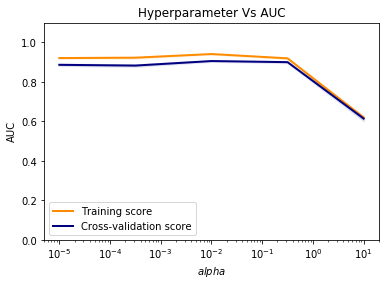

In [75]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="roc_auc", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Hyperparameter Vs AUC")
plt.xlabel("$alpha$")
plt.ylabel("AUC")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

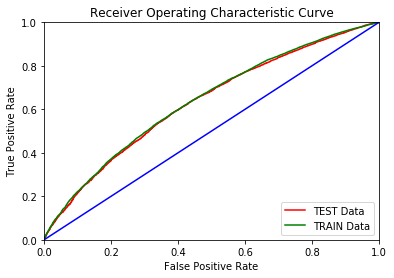

In [53]:
from cycler import cycler
fpr, tpr, threshold = metrics.roc_curve(Y_test, (X_test_vec_standardized)[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(Y_train, (X_train_vec_standardized)[:,1])

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_alpha, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))


Test Accuracy Of Classifier C = 0.010 is 88.341182%

Test Precsion Of Classifier C = 0.010 is 0.894444

Test recall  Of Classifier C = 0.010 is 0.976287

Test F1-score  Of Classifier C = 0.010 is 0.933576


Train Confusion Matrix
[[ 4213  5734]
 [ 1346 50148]]
Test Confusion Matrix
[[ 1756  2478]
 [  557 21541]]


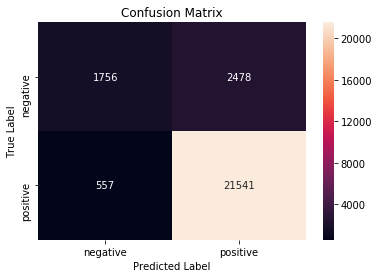

In [53]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, sgd.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### RandomSearchCV (SGDClassifier with Hinge-Loss)

In [77]:
from scipy.stats import uniform
# create regularization hyperparameter distribution using uniform distribution
Alpha = uniform(loc=0,scale=1)
# create hyperparamaters options
hyperparameters = dict(alpha=Alpha)
# Using RandomSearchCv
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The Optimal value Of Aplha(1/C) is : ", optimal_alpha)

#SGDClassifier with  Optimal value of alpha:(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized, Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Predict probabilistic response
pred_prob = calib.predict_proba(X_test_vec_standardized)[:,1]

#varibles will be used at conclusion part
avg_w2V_random_alpha = optimal_alpha
avg_w2V_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2V_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.1195314442973181, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of model :  0.911374239533
The Optimal value Of Aplha(1/C) is :  0.119531444297


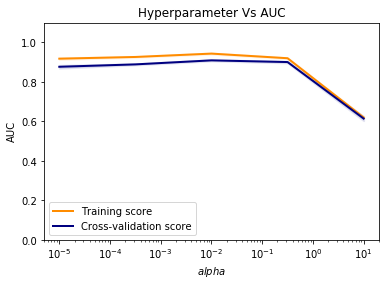

In [78]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="roc_auc", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Hyperparameter Vs AUC")
plt.xlabel("$alpha$")
plt.ylabel("AUC")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

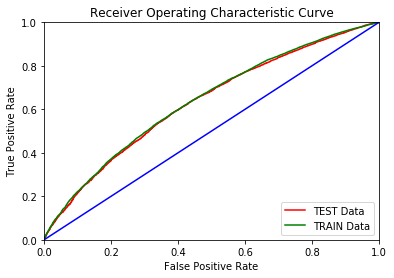

In [54]:
from cycler import cycler
fpr, tpr, threshold = metrics.roc_curve(Y_test, (X_test_vec_standardized)[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(Y_train, (X_train_vec_standardized)[:,1])

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [55]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_alpha, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))


Test Accuracy Of Classifier C = 0.168 is 85.170135%

Test Precsion Of Classifier C = 0.168 is 0.850418

Test recall  Of Classifier C = 0.168 is 0.999004

Test F1-score  Of Classifier C = 0.168 is 0.918742


Train Confusion Matrix
[[  816  9131]
 [   60 51434]]
Test Confusion Matrix
[[  351  3883]
 [   22 22076]]


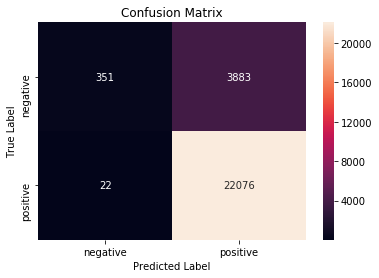

In [56]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, sgd.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:
* SGD Classifier with HInge-Loss On AvgWord2Vec observed an AUC of 0.886 with an APlha 0.1.

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [55]:
# Please write all the code with proper documentation
# collect different 100k rows without repetition from time_sorted_data DataFrfame
my_final = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(my_final.shape)

x = my_final['cleanedText'].values
y = my_final['Score']
#SPlit the dataset into Train and Test
X_train,X_test,Y_train,Y_test=train_test_split(x, y, test_size=0.3, random_state=0)

#List of sentance in X_train text
sent_of_train = []
for sent in X_train:
    sent_of_train.append(sent.split())
    
#List of sentance in X_test text
sent_of_test = []
for sent in X_test:
    sent_of_test.append(sent.split())
#Train your own text corpus WOrd2Vec
w2v_model = Word2Vec(sent_of_train,min_count=5,size=50,workers=4)   
w2v_words = list(w2v_model.wv.vocab)

(87773, 11)


In [56]:
# Please write all the code with proper documentation
#TF-IDF weighted word2vec
tf_idf_vect = TfidfVectorizer()
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)
tfidf_feat=tf_idf_vect.get_feature_names()

#compute TFIDF weighted word2vec of each review of X_train
#copute AvgWord2Vec for each review of X_train
tfidf_train_vectors = [];
row=0;
for sent in sent_of_train:
    sent_vec = np.zeros(50)
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  

In [61]:
tfidf_test_vectors = [];
row=0;
for sent in sent_of_test:
    sent_vec = np.zeros(50)
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1  
#Standardizing
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(tfidf_train_vectors)
X_test_vec_standardized = sc.transform(tfidf_test_vectors)

#### GridSearch CV

In [62]:
Alpha = [0.001, 0.01, 0.1, 1, 10]
param_grid={'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The Optimal value Of alpha(1/C) is : ", optimal_alpha)

#SGDClassifier with  Optimal value of alpha:(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized, Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Predict probabilistic response
#pred_prob = calib.predict_proba(X_test_vec_standardized)[:,1]

#varibles will be used at conclusion part
tfidf_w2v_grid_alpha = optimal_alpha
tfidf_w2v_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of model :  0.619521264609
The Optimal value Of alpha(1/C) is :  0.01


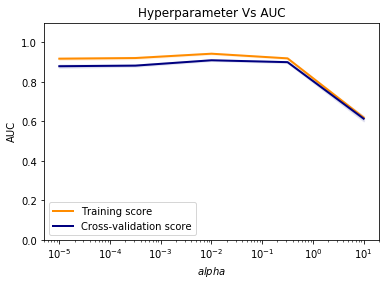

In [82]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="roc_auc", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Hyperparameter Vs AUC")
plt.xlabel("$alpha$")
plt.ylabel("AUC")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

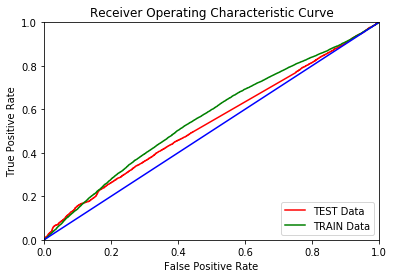

In [63]:
from cycler import cycler
fpr, tpr, threshold = metrics.roc_curve(Y_test, (X_test_vec_standardized)[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(Y_train, (X_train_vec_standardized)[:,1])

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [61]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_alpha, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))


Test Accuracy Of Classifier C = 0.010 is 77.726720%

Test Precsion Of Classifier C = 0.010 is 0.855276

Test recall  Of Classifier C = 0.010 is 0.884615

Test F1-score  Of Classifier C = 0.010 is 0.869699


Train Confusion Matrix
[[ 2880  7095]
 [  820 50646]]
Test Confusion Matrix
[[  894  3312]
 [ 2553 19573]]


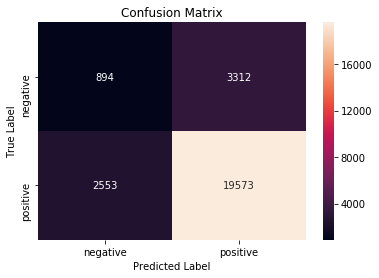

In [62]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, sgd.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### RandomSearchCV

In [84]:
from scipy.stats import uniform
# create regularization hyperparameter distribution using uniform distribution
Alpha = uniform(loc=0,scale=1)
# create hyperparamaters options
hyperparameters = dict(alpha=Alpha)
# Using RandomSearchCv
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The Optimal value Of Aplha(1/C) is : ", optimal_alpha)

#SGDClassifier with  Optimal value of alpha:(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized, Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Predict probabilistic response
pred_prob = calib.predict_proba(X_test_vec_standardized)[:,1]

#varibles will be used at conclusion part
tfidf_w2V_random_alpha = optimal_alpha
tfidf_w2V_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2V_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.066418464654816156, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of model :  0.9144603335
The Optimal value Of Aplha(1/C) is :  0.0664184646548


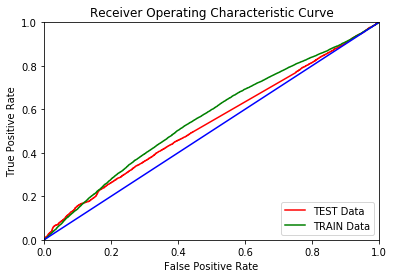

In [64]:
from cycler import cycler
fpr, tpr, threshold = metrics.roc_curve(Y_test, (X_test_vec_standardized)[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(Y_train, (X_train_vec_standardized)[:,1])

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [64]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %.3f is %f%%' % (optimal_alpha, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %.3f is %f' % (optimal_alpha, acc))


Test Accuracy Of Classifier C = 0.023 is 78.657147%

Test Precsion Of Classifier C = 0.023 is 0.853781

Test recall  Of Classifier C = 0.023 is 0.900163

Test F1-score  Of Classifier C = 0.023 is 0.876359


Train Confusion Matrix
[[ 2359  7616]
 [  590 50876]]
Test Confusion Matrix
[[  795  3411]
 [ 2209 19917]]


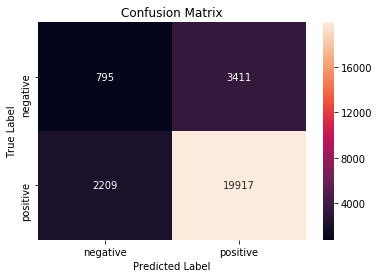

In [65]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, sgd.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, sgd.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## [5.2] RBF SVM

#### Randomly sampling 40k data points out of whole dataset

In [65]:
# collect different 40k rows without repetition from time_sorted_data DataFrfame
my_final = time_sorted_data.take(np.random.permutation(len(final))[:40000])
print(my_final.shape)

x = my_final['cleanedText'].values
y = my_final['Score']
#SPlit the dataset into Train and Test
X_train,X_test,Y_train,Y_test=train_test_split(x, y, test_size=0.3, random_state=0)

#Bow
count_vect = CountVectorizer(min_df =100)
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_vec))
print("the shape of out text BOW vectorizer ",X_train_vec.get_shape())
print("the number of unique words ", X_train_vec.get_shape()[1])
    
#Standardizing
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

(40000, 11)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (28000, 1318)
the number of unique words  1318


### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [67]:
# Please write all the code with proper documentation
from sklearn.svm import SVC
C_range=[1,2,4,8,16,32]
param_grid = {'C': C_range}
model = GridSearchCV(SVC(), param_grid, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C is : ", optimal_C)

#SVC with RBF KErnel  Optimal value of C:
svc = SVC(C=optimal_C)
svc.fit(X_train_vec_standardized, Y_train)
predictions = svc.predict(X_test_vec_standardized)

# Predict probabilistic response
pred_prob = calib.predict_proba(X_test_vec_standardized)[:,1]

Model with best parameters :
 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of model :  0.918771277922
The Optimal value Of C is :  1


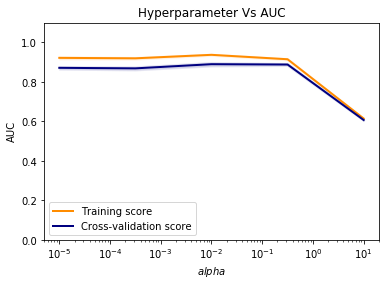

In [32]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="roc_auc", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Hyperparameter Vs AUC")
plt.xlabel("$alpha$")
plt.ylabel("AUC")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

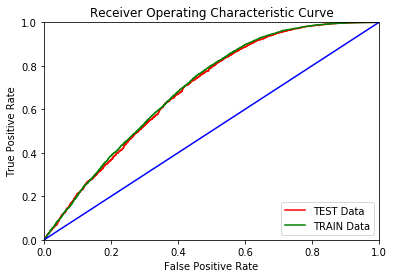

In [73]:
from cycler import cycler
fpr, tpr, threshold = metrics.roc_curve(Y_test, calib.predict_proba(X_test_vec_standardized)[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(Y_train, calib.predict_proba(X_train_vec_standardized)[:,1])

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [70]:
#Evaluate Accuracy
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %d is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %d is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %d is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %d is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 4 is 90.583333%

Test Precsion Of Classifier C = 4 is 0.917723

Test recall  Of Classifier C = 4 is 0.975535

Test F1-score  Of Classifier C = 4 is 0.945746


Train Confusion Matrix
[[ 4183   422]
 [   41 23354]]
Test Confusion Matrix
[[1021  883]
 [ 247 9849]]


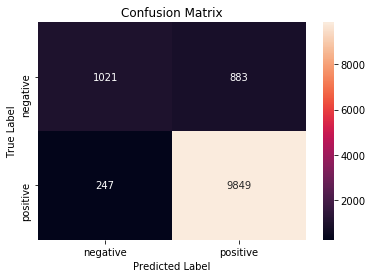

In [71]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, svc.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, svc.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, svc.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Obseravtion:
* Observed an AUC of 0.905 with an optimal ALpha of 4, with RBF Kernel method implementation.

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [74]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings("ignore")


# collect different 40k rows without repetition from time_sorted_data DataFrfame
my_final = time_sorted_data.take(np.random.permutation(len(final))[:20000])
print(my_final.shape)

x = my_final['cleanedText'].values
y = my_final['Score']
#SPlit the dataset into Train and Test
X_train,X_test,Y_train,Y_test=train_test_split(x, y, test_size=0.3, random_state=0)


tf_idf_vect = TfidfVectorizer(min_df=10)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_vec))
print("the shape of out text TFIDF vectorizer ",X_train_vec.get_shape())
print("the number of unique words ", X_train_vec.get_shape()[1])
    
#Standardizing
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)


(20000, 11)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (14000, 3382)
the number of unique words  3382


#### Note:
* Considering Sample of 20k as GridSearchCV is taking lot of time to run with 40k points with RBF kernel.

In [87]:
# Please write all the code with proper documentation

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
C_range=[1,2,4,8,16,32]
param_grid = {'C': C_range}
model = GridSearchCV(SVC(), param_grid, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C is : ", optimal_C)

#SVC with RBF KErnel  Optimal value of C:
svc = SVC(C=optimal_C)
svc.fit(X_train_vec_standardized, Y_train)
predictions = svc.predict(X_test_vec_standardized)

# Predict probabilistic response
pred_prob = calib.predict_proba(X_test_vec_standardized)[:,1]

Model with best parameters :
 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of model :  0.900796007685
The Optimal value Of C is :  1


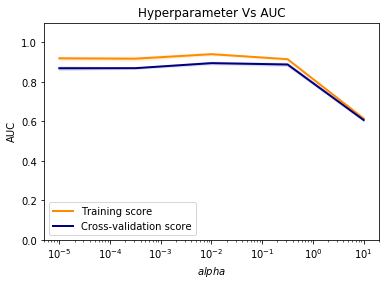

In [34]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="roc_auc", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Hyperparameter Vs AUC")
plt.xlabel("$alpha$")
plt.ylabel("AUC")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

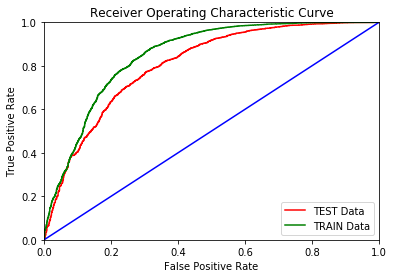

In [88]:
from cycler import cycler
fpr, tpr, threshold = metrics.roc_curve(Y_test, calib.predict_proba(X_test_vec_standardized)[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(Y_train, calib.predict_proba(X_train_vec_standardized)[:,1])

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
#Evaluate Accuracy
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy import *
from scipy.sparse import *
from scipy.stats import uniform
from prettytable import PrettyTable
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %d is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %d is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %d is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %d is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 4 is 89.266667%

Test Precsion Of Classifier C = 4 is 0.900747

Test recall  Of Classifier C = 4 is 0.980377

Test F1-score  Of Classifier C = 4 is 0.938876


Train Confusion Matrix
[[ 2248    16]
 [    1 11735]]
Test Confusion Matrix
[[ 410  545]
 [  99 4946]]


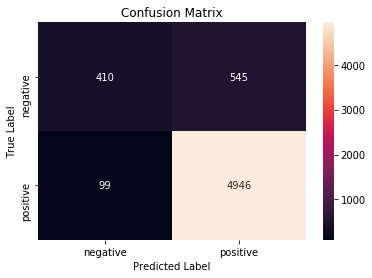

In [31]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, svc.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, svc.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, svc.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:
* obsreved an AUC of 0.892 with an Hyperparameter of 4, with RBF Kernel implementation.
* Performing well on BOW and TFIDF
* Considering only 20k datapoints as it is RBF is time complex.

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [104]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
#List of sentance in X_train text
sent_of_train = []
for sent in X_train:
    sent_of_train.append(sent.split())
    
#List of sentance in X_test text
sent_of_test = []
for sent in X_test:
    sent_of_test.append(sent.split())
#Train your own text corpus WOrd2Vec
w2v_model = Word2Vec(sent_of_train,min_count=5,size=50,workers=4)   
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5287
sample words  ['kitti', 'receiv', 'bag', 'treat', 'christma', 'friend', 'run', 'hear', 'take', 'kitchen', 'drawer', 'pretti', 'finicki', 'absolut', 'love', 'order', 'lot', 'amazon', 'yum', 'tri', 'first', 'time', 'littl', 'unsur', 'huge', 'fan', 'almond', 'anyth', 'banana', 'flavor', 'boy', 'glad', 'theyr', 'realli', 'yummi', 'perfect', 'pick', 'snack', 'school', 'work', 'tast', 'even', 'delici', 'warm', 'true', 'connoisseur', 'chocol', 'interest', 'new', 'dark']


In [105]:
#copute AvgWord2Vec for each review of X_train
train_vectors = [];
for sent in sent_of_train:
    sent_vec = np.zeros(50)
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)

#compute AvgWord2Vec for each review of X_test
test_vectors = [];
for sent in sent_of_test:
    sent_vec = np.zeros(50)
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)

#Standardizing
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(train_vectors)
X_test_vec_standardized = sc.transform(test_vectors)

In [106]:
# Please write all the code with proper documentation

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
C_range=[1,2,4,8,16,32]
param_grid = {'C': C_range}
model = GridSearchCV(SVC(), param_grid, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C is : ", optimal_C)

#SVC with RBF KErnel  Optimal value of C:
svc = SVC(C=optimal_C)
svc.fit(X_train_vec_standardized, Y_train)
predictions = svc.predict(X_test_vec_standardized)

# Predict probabilistic response
#pred_prob = calib.predict_proba(X_test_vec_standardized)[:,1]

Model with best parameters :
 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of model :  0.855325760684
The Optimal value Of C is :  1


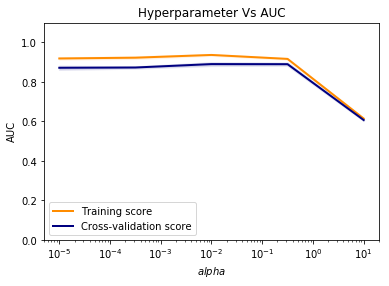

In [36]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="roc_auc", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Hyperparameter Vs AUC")
plt.xlabel("$alpha$")
plt.ylabel("AUC")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

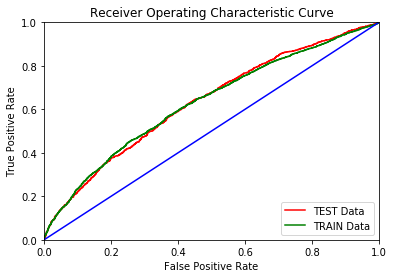

In [107]:
from cycler import cycler
fpr, tpr, threshold = metrics.roc_curve(Y_test, (X_test_vec_standardized)[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(Y_train, (X_train_vec_standardized)[:,1])

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
#Evaluate Accuracy
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy import *
from scipy.sparse import *
from scipy.stats import uniform
from prettytable import PrettyTable
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %d is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %d is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %d is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %d is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 4 is 87.750000%

Test Precsion Of Classifier C = 4 is 0.894544

Test recall  Of Classifier C = 4 is 0.968484

Test F1-score  Of Classifier C = 4 is 0.930047


Train Confusion Matrix
[[ 1161  1103]
 [  230 11506]]
Test Confusion Matrix
[[ 379  576]
 [ 159 4886]]


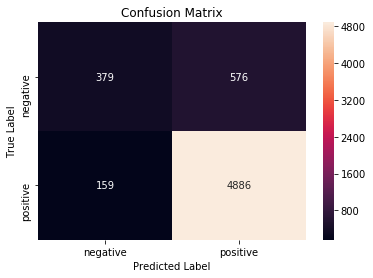

In [36]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(Y_train, svc.predict(X_train_vec_standardized)))
print("Test Confusion Matrix")
print(confusion_matrix(Y_test, svc.predict(X_test_vec_standardized)))
cm_test=confusion_matrix(Y_test, svc.predict(X_test_vec_standardized))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:
* obsreved an AUC of 0.892 with an Hyperparameter of 4, with RBF Kernel implementation.
* Performing well on BOW and TFIDF, but no performing on AvgW2V text data.

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [112]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# collect different 100k rows without repetition from time_sorted_data DataFrfame
my_final = time_sorted_data.take(np.random.permutation(len(final))[:20000])
print(my_final.shape)

x = my_final['cleanedText'].values
y = my_final['Score']
#SPlit the dataset into Train and Test
X_train,X_test,Y_train,Y_test=train_test_split(x, y, test_size=0.3, random_state=0)

#List of sentance in X_train text
sent_of_train = []
for sent in X_train:
    sent_of_train.append(sent.split())
    
#List of sentance in X_test text
sent_of_test = []
for sent in X_test:
    sent_of_test.append(sent.split())
#Train your own text corpus WOrd2Vec
w2v_model = Word2Vec(sent_of_train,min_count=5,size=50,workers=4)   
w2v_words = list(w2v_model.wv.vocab)

(20000, 11)


In [113]:
# Please write all the code with proper documentation
#TF-IDF weighted word2vec
tf_idf_vect = TfidfVectorizer()
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)
tfidf_feat=tf_idf_vect.get_feature_names()

#compute TFIDF weighted word2vec of each review of X_train
#copute AvgWord2Vec for each review of X_train
tfidf_train_vectors = [];
row=0;
for sent in sent_of_train:
    sent_vec = np.zeros(50)
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  

In [114]:
# Please write all the code with proper documentation

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
C_range=[1,2,4,8,16,32]
param_grid = {'C': C_range}
model = GridSearchCV(SVC(), param_grid, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n", model.best_estimator_)
print("Accuracy of model : ", model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The Optimal value Of C is : ", optimal_C)

#SVC with RBF KErnel  Optimal value of C:
svc = SVC(C=optimal_C)
svc.fit(X_train_vec_standardized, Y_train)
predictions = svc.predict(X_test_vec_standardized)

# Predict probabilistic response
#pred_prob = calib.predict_proba(X_test_vec_standardized)[:,1]

Model with best parameters :
 SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of model :  0.503121211647
The Optimal value Of C is :  4


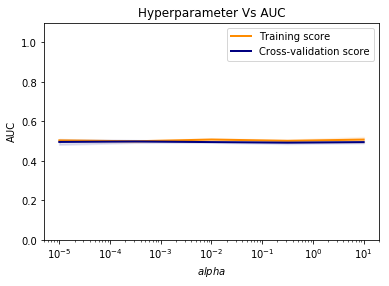

In [110]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve


param_range = np.logspace(-5, 1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(),X_train_vec_standardized, Y_train, param_name="alpha", param_range=param_range,
    cv=3, scoring="roc_auc", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Hyperparameter Vs AUC")
plt.xlabel("$alpha$")
plt.ylabel("AUC")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

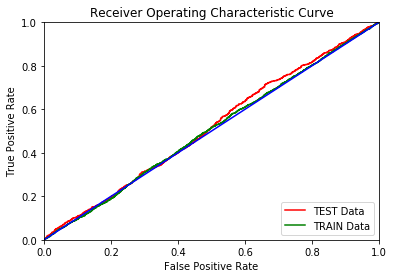

In [115]:
from cycler import cycler
fpr, tpr, threshold = metrics.roc_curve(Y_test, (X_test_vec_standardized)[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(Y_train, (X_train_vec_standardized)[:,1])

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
f, ax = plt.subplots()
plt.title('Receiver Operating Characteristic Curve')
cy = cycler('color', ['red', 'green', 'blue'])
ax.set_prop_cycle(cy)
ax.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

ax.plot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
#Evaluate Accuracy
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy import *
from scipy.sparse import *
from scipy.stats import uniform
from prettytable import PrettyTable
acc = accuracy_score(Y_test, predictions)* 100
print('\nTest Accuracy Of Classifier C = %d is %f%%' % (optimal_C, acc))

#Evaluate Precision
acc = precision_score(Y_test, predictions)
print('\nTest Precsion Of Classifier C = %d is %f' % (optimal_C, acc))

#Evaluate Recall
acc = recall_score(Y_test, predictions)
print('\nTest recall  Of Classifier C = %d is %f' % (optimal_C, acc))

#Evaluate F1-score
acc = f1_score(Y_test, predictions)
print('\nTest F1-score  Of Classifier C = %d is %f' % (optimal_C, acc))


Test Accuracy Of Classifier C = 1 is 84.016667%

Test Precsion Of Classifier C = 1 is 0.840167

Test recall  Of Classifier C = 1 is 1.000000

Test F1-score  Of Classifier C = 1 is 0.913142


#### Observation:
* obsreved an AUC of 0.842 with an Hyperparameter of 1, with RBF Kernel implementation.
* Performing well on BOW and TFIDF text data, but considerbally less with TFDIF Word2vec.
* Considering only 20k datapoints as it is RBF is time complex.

# [6] Conclusions

In [44]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Feature Engineering", "Hyperparameter(Alpha:1/C)", "AUC"]
x.add_row(["BOW", "GridSearchCV SGD", 0.1, 0.912])
x.add_row(["BOW", "RandomSearch SGD", 0.89, 0.913])
x.add_row(["TFDIF", "GridSearchCV SGD", 0.1, 0.910])
x.add_row(["TFDIF", "RandomSearchCV SGD", 0.04, 0.913])
x.add_row(["AVG Word2Vec", "GridSearchCV SGD", 0.01, 0.886])
x.add_row(["AVG Word2Vec", "RandomSearchCV SGD", 0.167, 0.852])
x.add_row(["TFDIF Word2Vec", "GridSearchCV SGD", 0.01, 0.781])
x.add_row(["TFDIF Word2Vec", "RandomSearchCV SGD", 0.023, 0.788])

x.add_row(["BOW", "GridSearchCV RBF", 4, 0.904])
x.add_row(["TFIDF", 'RandomSearchCV RBF', 4, 0.892])
x.add_row(["AVG Word2Vec", "GridSearchCV RBF", 4, 0.877])
x.add_row(["TFDIF Word2Vec", "RandomSearchCV RBF", 1, 0.840])

print(x)

+----------------+---------------------+---------------------------+-------+
|   Vectorizer   | Feature Engineering | Hyperparameter(Alpha:1/C) |  AUC  |
+----------------+---------------------+---------------------------+-------+
|      BOW       |   GridSearchCV SGD  |            0.1            | 0.912 |
|      BOW       |   RandomSearch SGD  |            0.89           | 0.913 |
|     TFDIF      |   GridSearchCV SGD  |            0.1            |  0.91 |
|     TFDIF      |  RandomSearchCV SGD |            0.04           | 0.913 |
|  AVG Word2Vec  |   GridSearchCV SGD  |            0.01           | 0.886 |
|  AVG Word2Vec  |  RandomSearchCV SGD |           0.167           | 0.852 |
| TFDIF Word2Vec |   GridSearchCV SGD  |            0.01           | 0.781 |
| TFDIF Word2Vec |  RandomSearchCV SGD |           0.023           | 0.788 |
|      BOW       |   GridSearchCV RBF  |             4             | 0.904 |
|     TFIDF      |  RandomSearchCV RBF |             4             | 0.892 |

* Applied SGD Classifier on BOW, TFIDF, AvgW2v, TFIDF Word2Vec four vectorizers.
* Using GridSearch CV and Random SearchCV , on time series based split data .
* Observed that SGD classifier works well with BOW, TFIDF but didn't perform well on Tfidf WOrd2Vec text data.
* Coming to RBF Kernel implementation works well similar to SGD calssifier as it's taking time to run the GridSearchCv
  with the large data points.
* In this case SGD is cosniderabally good.
* RBF is time complexity.
* Deployed SGD classifier with 100k data points using GridCV, RandomCV.
* Deployed RBF Kernel with 20k datapoints as it is time complex.